In [1]:
from google.colab import files
uploaded = files.upload()

Saving Titanic-Dataset.csv to Titanic-Dataset.csv


Dataset loaded! Time to explore what we’re dealing with.
Missing values before cleaning:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


/tmp/ipython-input-4-1382482628.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-4-1382482628.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

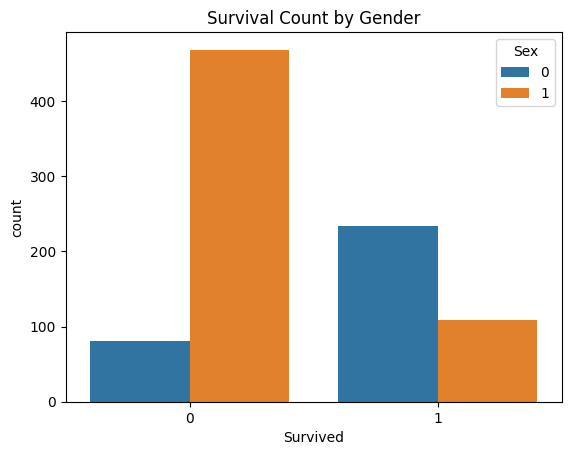

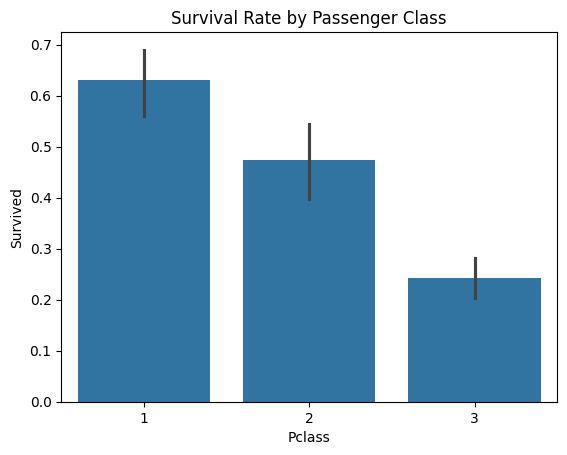

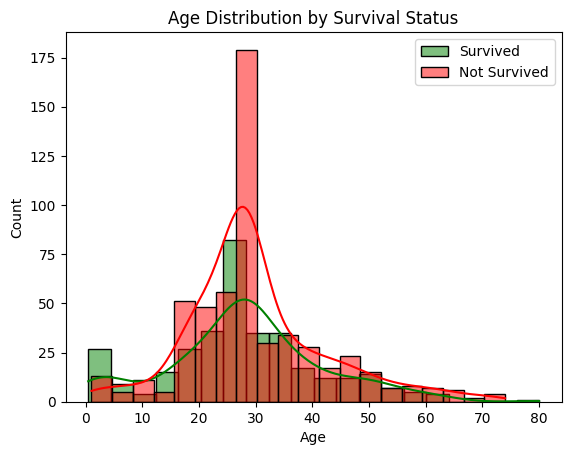

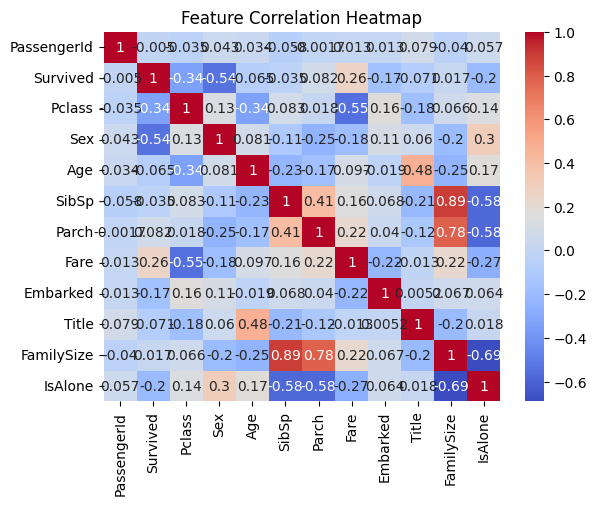


Trying out a few models to compare their performance:

Random Forest Accuracy: 0.8380
Logistic Regression Accuracy: 0.8045
XGBoost Accuracy: 0.7989

How well did it do on the test set?
Accuracy: 0.8379888268156425

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86       105
           1       0.81      0.80      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:16:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


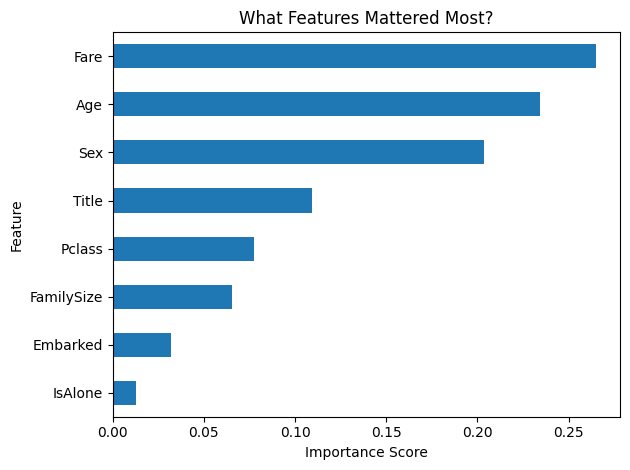

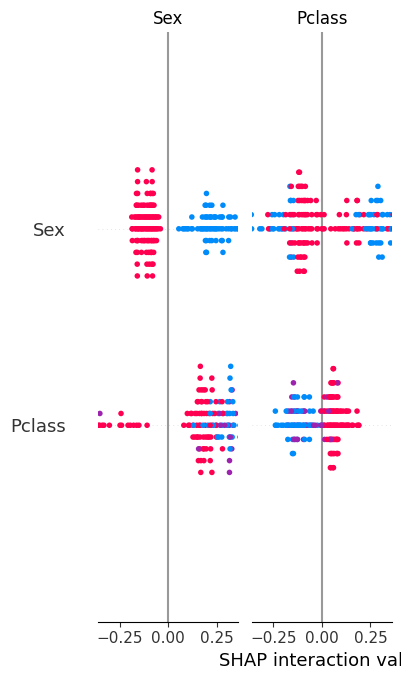


🔍 Real-World Framing:
This model could hypothetically assist in designing smarter evacuation policies for modern ships.

⚖️ Ethical Reflection:
Of course, this is purely academic. No real-life decisions should be made using this model.

✅ Done! Titanic Survival Prediction is complete. Learned a lot doing this one!


In [4]:
# 📘 Titanic Survival Prediction -Data Science Internship Project
# Author: [ASHITHA T]
# Type: Applied ML Case Study with Interpretability
# Goal: Build a model to predict passenger survival using meaningful features, interpret results, and reflect real-world context.

# --- Step 1: Importing required libraries  ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Step 2: Load Dataset ---
df = pd.read_csv("Titanic-Dataset.csv")
print("Dataset loaded! Time to explore what we’re dealing with.")
df.head()

# --- Step 3: Data Cleaning ---
# Checking missing values
print("Missing values before cleaning:\n", df.isnull().sum())

# Filling missing age values with median to reduce outlier impact
df['Age'].fillna(df['Age'].median(), inplace=True)
# 'Embarked' is categorical — using mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
# Dropping 'Cabin' — too many missing values, would require separate treatment
df.drop('Cabin', axis=1, inplace=True)

# --- Step 4: Feature Engineering (my favorite part!) ---
# Extracting titles from names to capture social status or role
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Creating a family size feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# Flag to check if someone is traveling alone
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# --- Step 5: Encoding Categorical Columns ---
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Title'] = le.fit_transform(df['Title'])

# --- Step 6: Feature Selection ---
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']
X = df[features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 7: EDA (What does the data say?) ---
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title('Survival Count by Gender')
plt.show()

sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Passenger Class')
plt.show()

sns.histplot(df[df['Survived'] == 1]['Age'], bins=20, label='Survived', color='green', kde=True)
sns.histplot(df[df['Survived'] == 0]['Age'], bins=20, label='Not Survived', color='red', kde=True)
plt.legend()
plt.title('Age Distribution by Survival Status')
plt.show()

sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')

plt.title('Feature Correlation Heatmap')
plt.show()

# ✍️ Observation:
# Women and passengers in 1st class had higher survival rates. Age also seems like an influential factor.

# --- Step 8: Try Out a Few Models ---
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=200),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

print("\nTrying out a few models to compare their performance:\n")
for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")

# Final pick: Random Forest gave the best accuracy in my case
model = models['Random Forest']

# --- Step 9: Evaluation ---
y_pred = model.predict(X_test)
print("\nHow well did it do on the test set?")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Step 10: Feature Importance ---
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='What Features Mattered Most?')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- SHAP Explainability (optional but cool) ---
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


# --- Real-World Reflection ---
print("\n🔍 Real-World Framing:")
print("This model could hypothetically assist in designing smarter evacuation policies for modern ships.")

print("\n⚖️ Ethical Reflection:")
print("Of course, this is purely academic. No real-life decisions should be made using this model.")

# --- Final Message ---
print("\n✅ Done! Titanic Survival Prediction is complete. Learned a lot doing this one!")
